In [1]:
from tensorflow.python.framework.ops import disable_eager_execution
from tensorflow.python.framework.ops import enable_eager_execution
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import backend as kb
from tensorflow.keras.layers import Input, TimeDistributed, Flatten, Lambda, Concatenate, Reshape, LSTM, RepeatVector, SimpleRNN, Activation, Dense
from tensorflow.keras import initializers
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import layers, models, optimizers, callbacks
from datetime import datetime
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import re
import os
import warnings
import json
import gc
import matplotlib.pyplot as plt
from matplotlib import pyplot
from os.path import expanduser

In [2]:
# a = np.load('/srv/scratch/mmwave/Testing_Set/Falling/sample0/sample_data.npy', allow_pickle=True)
# print(a)

In [3]:
# os.chdir(expanduser("~") + '/data_analysis_mmwave')
os.chdir(expanduser("~") + '/data_analysis_mmwave')
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# disable_eager_execution() # toggle on and off based on if u have training/validation

# INITIAL VALUES
epochs = 100
ARRAY_CHUNKS = 1000
frame_window_size = 20
TIMESTAMP = 0
X = 2
Y = 3
Z = 4
DOPPLER = 5
MAX_POINT_FRAME = -1
STEP_SIZE = 1
print("hello")

hello


In [4]:
# removing test set from input
#
os.getcwd()
# scratch
ADL_Directories = os.listdir('/srv/scratch/mmwave/Data_Input/')
# local
# ADL_Directories = os.listdir('Data_Input/')
ADL_Directories.remove('Falling')
Falling_Directories = ['Falling']
# this will define where the data is located
# scratch
shared_drive_prefix = '/srv/scratch/mmwave/'
# local
#shared_drive_prefix = ''


Array_DIR_Train = shared_drive_prefix
Array_DIR_Test = shared_drive_prefix
Frame_DIR_Stats = "Frame_Statistics/"
Training_DIR = "Training_Results/"
print(Array_DIR_Train)

if os.path.exists(Array_DIR_Train) is False:
    os.mkdir(Array_DIR_Train)
if os.path.exists(Frame_DIR_Stats) is False:
    os.mkdir(Frame_DIR_Stats)
if os.path.exists(Array_DIR_Test) is False:
    os.mkdir(Array_DIR_Test)
if os.path.exists(Training_DIR) is False:
    os.mkdir(Training_DIR)
if os.path.exists("/srv/scratch/mmwave/Checkpoints/") is False:
    os.mkdir("/srv/scratch/mmwave/Checkpoints/")

/srv/scratch/mmwave/


Computing Frame Statistic block

In [5]:
def compute_frame_statistics(train, test):
    max = -1
    min = 10000000
    average = 0
    histogram = {}
    count = 0
    for sample in train:
        for frame in sample.keys():
            histogram[frame] = len(sample[frame])
            average = average + len(sample[frame])
            count = count + 1
            if(len(sample[frame]) > max):
                max = len(sample[frame])
            if(len(sample[frame]) < min):
                min = len(sample[frame])

    for sample in test:
        for frame in sample.keys():
            histogram[frame] = len(sample[frame])
            average = average + len(sample[frame])
            count = count + 1
            if(len(sample[frame]) > max):
                max = len(sample[frame])
            if(len(sample[frame]) < min):
                min = len(sample[frame])
    with open(Frame_DIR_Stats + 'Frame_Histogram.json', 'w') as file:
        json.dump(histogram, file)
    with open(Frame_DIR_Stats + 'max_frame_size.json', 'w') as file:
        json.dump({"max": max, "min": min, "average": average/count}, file)


In [6]:
def print_histogram():
    histogram = {}
    with open(Frame_DIR_Stats + 'Frame_Histogram.json', 'r') as file:
        histogram = json.load(file)
    pyplot.hist(list(histogram.values()))
    pyplot.show()

In [7]:
def retrieve_max():
    if(os.path.exists(Frame_DIR_Stats + 'max_frame_size.json') is False):
        print("PLEASE UNCOMMENT THE STATISTICS BLOCK BELOW BEFORE RUNNING ANY OF THIS")
    stats = {}
    with open(Frame_DIR_Stats + 'max_frame_size.json', 'r') as file:
        stats = json.load(file)
    return stats['max']
MAX_POINT_FRAME = retrieve_max()
MAX_POINT_FRAME = MAX_POINT_FRAME + (16 - (MAX_POINT_FRAME % 16))


Data Preprocessing begins here

In [8]:
def generate_frame_sequences(raw_data_samples):
    frame_map_array = []
    count = 0
    sample_string = "sample_" + str(count)
    for sample in raw_data_samples:
        frame_map = {}
        for data in sample:
            timestamp = data[TIMESTAMP]+"_"+sample_string
            if timestamp in frame_map:
                frame_map[timestamp].append(np.array(data[[X, Y, Z, DOPPLER]]))
            else:
                frame_map[timestamp] = []
                frame_map[timestamp].append(np.array(data[[X, Y, Z, DOPPLER]]))
        count = count + 1
        sample_string = "sample_" + str(count)
        frame_map_array.append(frame_map)
    return frame_map_array

In [9]:
# def load_raw_data_sliding_window(Directory):
#     # want to load into samples vs a single dump
#     raw_data = []
#     for activity in Directory:
#         if activity == "Transitions":
#             for transition in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity):
#                 for orientation in os.listdir('/srv/scratch/mmwave/Data_Input/' + "/" + activity + "/" + transition):
#                     for subject in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity + "/" + transition + "/" + orientation):
#                         data = pd.read_csv(
#                             '/srv/scratch/mmwave/Data_Input/' + activity + "/" + transition + "/" + orientation + "/" + subject + "/points_cloud.csv")
#                         raw_data.append(data.to_numpy())
#         else:
#             for orientation in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity):
#                 for subject in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity + "/" + orientation):
#                     if not os.path.exists('/srv/scratch/mmwave/Data_Input/' + activity + "/" +
#                                        orientation + "/" + subject + "/points_cloud.csv"):
#                         continue
#                     data = pd.read_csv('/srv/scratch/mmwave/Data_Input/' + activity + "/" +
#                                        orientation + "/" + subject + "/points_cloud.csv")
#                     raw_data.append(data.to_numpy())
#     return raw_data
def load_raw_data_sliding_window(Directory):
    # want to load into samples vs a single dump
    raw_data = []
    for activity in Directory:
        if activity == "Transitions":
            for transition in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity):
                for orientation in os.listdir('/srv/scratch/mmwave/Data_Input/' + "/" + activity + "/" + transition):
                    for subject in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity + "/" + transition + "/" + orientation):
                        data = pd.read_csv(
                            '/srv/scratch/mmwave/Data_Input/' + activity + "/" + transition + "/" + orientation + "/" + subject + "/points_cloud.csv")
                        raw_data.append(data.to_numpy())
        else:
            for file in os.listdir('/srv/scratch/mmwave/Data_Input/' + activity):
                data = pd.read_csv('/srv/scratch/mmwave/Data_Input/' + activity +
                    "/" + file)
                raw_data.append(data.to_numpy())
    return raw_data

this method will process raw data, by oversampling the raw data with the proposed oversampling technique and proceed to
save the data to disk. it will only process unprocessed data.

In [10]:
def check_if_float_string(input):
    try:
        float(input)
        return True
    except ValueError:
        return False

In [11]:
def remove_junk(all_frames):
    clean_frames = []
    for frame in all_frames:
        add = True
        for point in frame:
            if not check_if_float_string(point[0]) or not check_if_float_string(point[1]) or not check_if_float_string(point[2]) or not check_if_float_string(point[3]):
                add = False
        if(add):
            clean_frames.append(frame)
    return clean_frames

In [12]:
def oversample_and_save_remaining_frames(frame_sequences, saved_array_parts, Array_DIR, TrainTest):
    sample_count = saved_array_parts
    for sample in frame_sequences[saved_array_parts:]:
        count = 0
        last_loaded_array_index = saved_array_parts
        all_frames = []
        for frame in sample.values():
            all_frames.append(frame)
        all_frames = remove_junk(all_frames)
        if(len(all_frames) == 0):
            continue;
        # pad if we are below window size
        while len(all_frames) <= frame_window_size:
            all_frames.append(np.zeros(np.shape(all_frames[0])))
        frame_sequence_array = []
        for i in range(0, len(all_frames) - frame_window_size, STEP_SIZE):
            frame_sequence_array.append([np.squeeze([all_frames[i:(i+frame_window_size)]])])
        # if there is still data to process, start from last save point
        processed_oversampled_frames_array = []
        processed_oversampled_frames = []
        for frame_batch in frame_sequence_array:
            batch = []
            for frame in np.squeeze(frame_batch):
                frame_sampled = oversample(frame)
                batch.append(np.array(frame_sampled))
            processed_oversampled_frames.append(np.array(batch))
            count += 1
        if os.path.exists(Array_DIR + TrainTest + "/") is False:
            os.mkdir(Array_DIR + TrainTest + "/")
        if os.path.exists(Array_DIR + TrainTest +"/sample"+str(sample_count)) is False:
            os.mkdir(Array_DIR + TrainTest +"/sample"+str(sample_count)+"/")
        frames_backup = []
        for val in processed_oversampled_frames:
            if (np.shape(val) == (20,272,4)):
                frames_backup.append(val)
        processed_oversampled_frames = frames_backup
        np.save(Array_DIR + TrainTest +"/sample"+str(sample_count)+"/sample_data", np.array(
                    processed_oversampled_frames), allow_pickle=True, fix_imports=True)
        sample_count = sample_count + 1

This method will load any data that is saved during raw data processing, this saves time making sure there is no duplicate pre-processing

In [13]:
def load_saved_array_data(saved_array_parts, Array_Dir, TrainTest):
    processed_oversampled_frames = []
    clean_frames = []
    if saved_array_parts > 0:
        for i in range(saved_array_parts):
            array_part = np.load(Array_Dir + TrainTest + "sample"+ str(i)+"/sample_data" + ".npy", allow_pickle=True)
            clean_frames.append(np.array(array_part).astype('float64'))
#             clean_frames.append(np.array(array_part).astype('float64')/255.0)
            processed_oversamples_frames = []
    return clean_frames

In [14]:
def loss(y_t, y_p, output_mean, output_log_variance):
    batch_size = kb.int_shape(y_t)[0]
    number_of_frames = kb.int_shape(y_t)[1]
    number_of_features = kb.int_shape(y_t)[-1]
    predicted_mean = y_p[:, :, :, :number_of_features]
    predicted_log_variance = y_p[:, :, :, number_of_features:]
    predicted_variance = kb.exp(predicted_log_variance)

    true_reshape = kb.reshape(y_t, (batch_size, number_of_frames, -1))
    mean_reshape = kb.reshape(
        predicted_mean, (batch_size, number_of_frames, -1))
    variance_reshape = kb.reshape(
        predicted_variance, (batch_size, number_of_frames, -1))
    log_variance_reshape = kb.reshape(
        predicted_log_variance, (batch_size, number_of_frames, -1))
    true_reshape = tf.cast(true_reshape, tf.float32)
    mean_reshape = tf.cast(mean_reshape, tf.float32)
    
    log_output = (kb.square(true_reshape - mean_reshape))/variance_reshape
    log_output = kb.sum(0.5*log_output, axis=-1)
    KL_loss = -0.5*kb.sum(1 + output_log_variance -
                          kb.square(output_mean) - kb.exp(output_log_variance), axis=-1)
    
    return kb.mean(log_output + KL_loss, 1)

In [15]:
def sample(inputs):
    input_mean, input_log_variance = inputs
    batch_size = kb.shape(input_mean)[0]
    number_of_frames = kb.int_shape(input_mean)[1]
    latent_dimension = kb.int_shape(input_mean)[2]
    epsilon = kb.random_normal(shape=(
        batch_size, number_of_frames, latent_dimension), mean=0., stddev=1.0, seed=None)
    return input_mean + kb.exp(0.5*input_log_variance) * epsilon

In [16]:
def oversample(data):
    data = np.array(data, dtype=np.float64)
    if(len(data) == 0):
        return []
    number_of_points = MAX_POINT_FRAME
    axis = np.shape(data)[0]
    mean = np.mean(data, axis=0)
    frame_np = np.sqrt(number_of_points/axis)*data + \
        mean - np.sqrt(number_of_points/axis)*mean
    oversampled_frame = frame_np.tolist()
    oversampled_frame.extend([mean]*(number_of_points-axis))
    oversampled_return = np.array(oversampled_frame)
    return oversampled_return

In [17]:
def load_mmData(Directory, TrainTest, Array_DIR):
    point_cloud_scatter_samples = load_raw_data_sliding_window(Directory)
    frame_sequences = generate_frame_sequences(point_cloud_scatter_samples)
    if os.path.exists(Array_DIR + TrainTest) is False:
        os.makedirs(Array_DIR + TrainTest)
    saved_array_parts = len(os.listdir(Array_DIR + TrainTest))
    oversample_and_save_remaining_frames(
        frame_sequences, saved_array_parts, Array_DIR, TrainTest)
    return load_saved_array_data(saved_array_parts, Array_DIR, TrainTest)

In [18]:
def train_HVRNNAE(training_set, testing_set):
    print("training_started")
    number_of_frames = frame_window_size
    number_of_points = MAX_POINT_FRAME
    number_of_features = 4

    encoding_dimension = MAX_POINT_FRAME
    latent_dimension = 16
    inputs = Input(
        shape=(number_of_frames, number_of_points, number_of_features))
    input_flatten = TimeDistributed(Flatten(None))(inputs)
    input_flatten = TimeDistributed(Dense(encoding_dimension, activation='tanh'))(input_flatten)
    input_mean = TimeDistributed(
        Dense(latent_dimension, activation=None), name='input_mean')(input_flatten)
    input_log_variance = TimeDistributed(
        Dense(latent_dimension, activation=None, kernel_initializer=initializers.Zeros()), name='input_log_variance')(input_flatten)
    sampled_input = Lambda(sample)([input_mean, input_log_variance])

    encoder = SimpleRNN(latent_dimension, activation='tanh',
                        return_sequences=False)(sampled_input)
    repeat_encoder = RepeatVector(number_of_frames)(encoder)
    decoder_RNN = SimpleRNN(
        latent_dimension, activation='tanh', return_sequences=True)(repeat_encoder)
    decoder = Lambda(lambda x: tf.reverse(x, axis=[-2]))(decoder_RNN)

    latent_input = TimeDistributed(
        Dense(encoding_dimension, activation='tanh'))(decoder)
    latent_mean = TimeDistributed(
        Dense(number_of_features, activation=None))(latent_input)
    latent_log_variance = TimeDistributed(
        Dense(number_of_features, activation=None))(latent_input)

    output = Concatenate()([latent_mean, latent_log_variance])
    output = TimeDistributed(RepeatVector(number_of_points))(output)
    outputs = TimeDistributed(
        Reshape((number_of_points, number_of_features*2)), name='test')(output)

    def HVRNNAE_loss(y_t, y_p):
        batch_size = kb.shape(y_t)[0]
        number_of_frames = kb.shape(y_t)[1]
        number_of_features = kb.shape(y_t)[-1]

        predicted_mean = y_p[:, :, :, :number_of_features]
        predicted_log_variance = y_p[:, :, :, number_of_features:]
        predicted_variance = kb.exp(predicted_log_variance)

        true_reshape = kb.reshape(y_t, (batch_size, number_of_frames, -1))
        mean_reshape = kb.reshape(
            predicted_mean, (batch_size, number_of_frames, -1))
        variance_reshape = kb.reshape(
            predicted_variance, (batch_size, number_of_frames, -1))
        log_variance_reshape = kb.reshape(
            predicted_log_variance, (batch_size, number_of_frames, -1))

        log_output = (kb.square(true_reshape - mean_reshape))/variance_reshape
        log_output = kb.sum(0.5*log_output, axis=-1)

        KL_loss = -0.5*kb.sum(1 + input_log_variance -
                              kb.square(input_mean) - kb.exp(input_log_variance), axis=-1)
        return kb.mean(log_output + KL_loss)

    model = Model(inputs, outputs)
    optimiser = optimizers.Adam(lr = 0.001, beta_1 = 0.9, beta_2 = 0.999, amsgrad=False)
    model.compile(optimizer=optimiser, loss=HVRNNAE_loss)
    checkpoint_path = "/srv/scratch/mmwave/Checkpoints/cp-{epoch:04d}.ckpt"
    checkpoint_dir = os.path.dirname(checkpoint_path)
    checkpoint_callback = ModelCheckpoint(
        checkpoint_path, save_weights_only=True, verbose=1)

    last_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    print("LAST CHECKPOINT -  ", last_checkpoint)
    remaining_epochs = epochs
    i_epoch = 0
    if last_checkpoint != None:
        checkpoint_number = re.search('cp-(\d+).ckpt', last_checkpoint)
        remaining_epochs = epochs - int(checkpoint_number.group(1))
        i_epoch = int(checkpoint_number.group(1))
        model.load_weights(last_checkpoint)
        print("Restored model from epoch ", str(checkpoint_number.group(1)),
              ", performing ", str(remaining_epochs), " epochs:")
    if remaining_epochs > 0:
        print("STARTING AT EPOCH ", i_epoch, " performing ", epochs-i_epoch, "epochs")
        model.fit(training_set, training_set, epochs=epochs, batch_size=2048, shuffle=True, initial_epoch=i_epoch,
                  validation_data=(testing_set, testing_set), verbose=1, callbacks=[checkpoint_callback])
    print("model finished training")
    return model

In [19]:
def predict(model, inference_data):
    # kb.clear_session()
    output_mean = Model(inputs=model.input,
                        outputs=model.get_layer('input_mean').output)
    output_log_variance = Model(
        inputs=model.input, outputs=model.get_layer('input_log_variance').output)
    predictions = []
    losses = []
    #for data in inference_data:
    #    inference_data = np.expand_dims(inference_data, axis=0)
    current_prediction = model.predict(inference_data, batch_size=1,verbose=1)
    predicted_output_mean = output_mean.predict(inference_data, batch_size=1)
    predicted_log_variance = output_log_variance.predict(
        inference_data, batch_size=1)
    current_loss = loss(inference_data, current_prediction,
                        predicted_output_mean, predicted_log_variance)
    return current_loss
    #losses.append(current_loss)
    #return losses

In [20]:
def split_dataset(falls, adl):
    # we want to count total sample in falls < - this will always ALWAYS be less
    count = 0
    for key in falls.keys():
        for sample in falls[key]:
            count = count + 1
    # now we want to see how many total activities are in the adl samples
    total_number_of_activities = 0
    for key in adl.keys():
        total_number_of_activities = total_number_of_activities + 1
    # to get the number of activities needed per sample we divide count by total number
    samples_needed_per_adl = int(count/total_number_of_activities)
    # to make this more fair i will randomly pick samples 
    print(samples_needed_per_adl)

In [21]:
def load_all():
    raw_training_data = load_raw_data_sliding_window(ADL_Directories)       #
    raw_testing_dta = load_raw_data_sliding_window(Falling_Directories)     #
    training_map = generate_frame_sequences(raw_training_data)              #
    testing_map = generate_frame_sequences(raw_testing_dta)                 #
    compute_frame_statistics(training_map, testing_map)                     #
    print_histogram()  

    MAX_POINT_FRAME = retrieve_max()
    MAX_POINT_FRAME = MAX_POINT_FRAME + (16 - (MAX_POINT_FRAME % 16))

    train_map = {}
    test_map = {}
    for activity in ADL_Directories:
        activity_samples = load_mmData([activity], "Training_Set/" + activity + "/" , Array_DIR_Train)
        train_map[activity] = activity_samples

    for activity in Falling_Directories:
        activity_samples = load_mmData([activity], "Testing_Set/" + activity + "/" , Array_DIR_Test)
        test_map[activity] = activity_samples    
    
    train_train1 = []
    train_validation_train1 = []
    train_validation_test1 = []
    test1 = []
    split_dataset(test_map, train_map)
    for key in train_map.keys():
        print(key)
        train_train1.append(np.squeeze(train_map[key][0:int(len(train_map[key])*.80)]))
        train_validation_train1.append(np.squeeze(train_map[key][int(len(train_map[key])*.80):int(len(train_map[key])*.90)]))
        train_validation_test1.append(np.squeeze(train_map[key][int(len(train_map[key])*.90):]))

    
    for key in test_map.keys():
        test1.append(np.squeeze(test_map[key]))

    train_train = []
    train_test = []
    train_validation_train = []
    train_validation_test = []
    test = []
    for key in train_train1:
        for sample in key:
            train_train.append(sample)
    for key in train_validation_train1:
        for sample in key:
            train_validation_train.append(sample)   
    for key in train_validation_test1:
        for sample in key:
            train_validation_test.append(sample)    
    for key in test1:
        for sample in key:
            test.append(sample)         

    return train_train, train_validation_train, train_validation_test, test

In [22]:
# load_all()

In [23]:
print("HI")
def save_train(path, data):
    if os.path.exists(path) is False:
        os.mkdir(path)
    np.save(path + "/data", np.array(data), allow_pickle=True, fix_imports=True)

HI


In [24]:
def check_directories():
    if(os.path.exists(Training_DIR +"fall_youden_losses/") is False or len(os.listdir(Training_DIR +"fall_youden_losses/")) != 1):
        return False
    if(os.path.exists(Training_DIR +"no_fall_youden_losses/") is False or len(os.listdir(Training_DIR +"no_fall_youden_losses/")) != 1):
        return False
    if(os.path.exists(Training_DIR +"fall_validation_losses/") is False or len(os.listdir(Training_DIR +"fall_validation_losses/")) != 1):
        return False
    if(os.path.exists(Training_DIR +"no_fall_validation_losses/") is False or len(os.listdir(Training_DIR +"no_fall_validation_losses/")) != 1):
        return False
    return True

In [25]:
# The block below will perform the following for optimality sake
# first it will check if the model has been trained AND has results --> having results in this case implies trained
# if it finds the results saved already, it will simply load them immediately no need to re-run model through test cases we already have the result
# if it finds ANY of the test cases are missing from the saved, it will re-run and save all results

# in this block here we first train the model with the test set, then split the testing set for validation
# we run the sample first through model, to get losses, and in end we return the losses for validation
# 1. training set -> 10,10, 10% for getting youdin index, 10% for validating youdin index
# 2. test set ->     50, 50, 50% for getting youdin index, 50% for validating youdin index

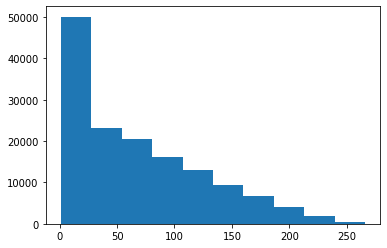

39
Background
Sit
LayFloor
Stand
LayBed
Walking
Transition
SitBed
266
316
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
WTF LMAO MEAN OVER 9
not crash
(80607, 20, 272, 4)
training_started


2021-11-22 14:53:50.544109: E tensorflow/stream_executor/cuda/cuda_driver.cc:313] failed call to cuInit: UNKNOWN ERROR (303)


LAST CHECKPOINT -   /srv/scratch/mmwave/Checkpoints/cp-0100.ckpt
Restored model from epoch  0100 , performing  0  epochs:
model finished training
150/150 [==============================] - 0s 2ms/step


In [26]:
if check_directories() is False:
    train_train, train_validation_train, train_validation_test, test = load_all()
    MAX_POINT_FRAME = retrieve_max()
    print(MAX_POINT_FRAME)
    MAX_POINT_FRAME = MAX_POINT_FRAME + (16 - (MAX_POINT_FRAME % 16))
    test_override = []
    
    for test_data in test:
        if(len(test_data) > 0):
            test_override.append(test_data)
    test = test_override
    print(len(test))

#     train_override = []
#     for train_data in test:
#         if(len(train_data) > 0):
#             train_override.append(train_data)
#     train = train_override


    # for training the model, we can just pass in 80% of samples as a flattened array, when we do testing we do sample by sample instead
    train_split = []
    # for train in train[int(len(train)*.80):]:
    #    test.append(train)
    # for training we flatten the split and validation
    for train_data in train_train:
        for data in train_data:
            if(len(data) > 0):
                if abs(np.mean(data)) < 2:
                    train_split.append(np.array(data))
                else:
                    print("WTF LMAO MEAN OVER 9")

    print("not crash")
    fall_test_validation_youden = []
    fall_test_validation = []

    no_fall_test_validation_youden = []
    no_fall_test_validation = []

    for train_data in train_validation_train:
        no_fall_test_validation_youden.append(train_data)   

    for train_data in train_validation_test:
        no_fall_test_validation.append(train_data)   

    for test_data in test[: int(len(test)*.50)]:
        fall_test_validation_youden.append(test_data)

    for test_data in test[int(len(test)*.50):]:
        fall_test_validation.append(test_data)

    # for test validation, the first 20% of the array int(len(train)*0.2) is negative samples, remainder positive samples
    del train_train
    del train_validation_train
    del train_validation_test
    del test
    print(np.shape(train_split))
    
    
    model = train_HVRNNAE(np.array(train_split), np.array(train_split))
    fall_youden_losses = []
    no_fall_youden_losses = []
    fall_validation_losses = []
    no_fall_validation_losses = []

    # we want to validate our model on test sample and save here, these will all be used for testing
    # run data in model, save losses in file

    for sample_data in fall_test_validation_youden:
        if len(sample_data) == 0:
            continue;
        if len(np.shape(sample_data))!= 4:
            sample_data = [sample_data]
            sample_data = np.array(sample_data)
        sample_losses = predict(model, sample_data)
        fall_youden_losses.append(np.array(sample_losses)) 
    save_train(Training_DIR +"fall_youden_losses/", fall_youden_losses)
    
    for sample_data in no_fall_test_validation_youden:
        if len(sample_data) == 0:
            continue;
        if len(np.shape(sample_data)) != 4:
            sample_data = [sample_data]
            sample_data = np.array(sample_data)
        sample_losses = predict(model, sample_data)
        no_fall_youden_losses.append(np.array(sample_losses))
    save_train(Training_DIR +"no_fall_youden_losses/", no_fall_youden_losses)

    for sample_data in fall_test_validation:
        if len(sample_data) == 0:
            continue;
        if len(np.shape(sample_data)) != 4:
            sample_data = [sample_data]
            sample_data = np.array(sample_data)
        sample_losses = predict(model, sample_data)
        fall_validation_losses.append(np.array(sample_losses))
    save_train(Training_DIR +"fall_validation_losses/", fall_validation_losses)

    for sample_data in no_fall_test_validation:
        if len(sample_data) == 0:
            continue;
        if len(np.shape(sample_data)) != 4:
            sample_data = [sample_data]
            sample_data = np.array(sample_data)
        sample_losses = predict(model, sample_data)
        no_fall_validation_losses.append(np.array(sample_losses))
    save_train(Training_DIR +"no_fall_validation_losses/", no_fall_validation_losses)

else:
    fall_youden_losses = np.load(Training_DIR + "fall_youden_losses/data.npy", allow_pickle=True)
    no_fall_youden_losses = np.load(Training_DIR + "no_fall_youden_losses/data.npy", allow_pickle=True)
    fall_validation_losses = np.load(Training_DIR + "fall_validation_losses/data.npy", allow_pickle=True)
    no_fall_validation_losses = np.load(Training_DIR + "no_fall_validation_losses/data.npy", allow_pickle=True)

In [27]:
#plt.hist(fall_youden_losses)
# plt.hist(no_fall_youden_losses)


In [28]:
# print the losses out in this cell here
# print("-------------------------- FALL LOSSES --------------------------")
# print(fall_youden_losses)
# print(fall_validation_losses)
# print("\n\n\n-------------------------- NO FALL LOSSES --------------------------")

# print(no_fall_youden_losses)
# print(no_fall_validation_losses)

In [29]:
FallValdLossesAll = np.empty((0,))
for i in range(len(fall_validation_losses)):
    FallValdLossesAll = np.concatenate((FallValdLossesAll,fall_validation_losses[i]))
FallValdLossesAll = np.asarray(FallValdLossesAll)

In [30]:
FallTrainLossesAll = np.empty((0,))
for i in range(len(fall_youden_losses)):
    FallTrainLossesAll = np.concatenate((FallTrainLossesAll,fall_youden_losses[i]))
FallTrainLossesAll = np.asarray(FallTrainLossesAll)    

In [31]:
NoFallValdLossesAll = np.empty((0,))
for i in range(len(no_fall_validation_losses)):
    NoFallValdLossesAll = np.concatenate((NoFallValdLossesAll,no_fall_validation_losses[i]))
NoFallValdLossesAll = np.asarray(NoFallValdLossesAll)    

In [32]:
NoFallTrainLossesAll = np.empty((0,))
for i in range(len(no_fall_youden_losses)):
    NoFallTrainLossesAll = np.concatenate((NoFallTrainLossesAll,no_fall_youden_losses[i]))
NoFallTrainLossesAll = np.asarray(NoFallTrainLossesAll) 

In [33]:
NoFallTrainLossesAllSort = np.sort(NoFallTrainLossesAll)

In [34]:
# np.min(FallValdLossesAll)

In [35]:
# plt.hist(NoFallTrainLossesAll)

In [36]:
# plt.hist(FallValdLossesAll)
# plt.hist(NoFallValdLossesAll)

In [37]:
N = NoFallTrainLossesAllSort.shape[0]
TPR = []
FPR = []
for k in range(N-1):
    TPR.append(np.sum(NoFallValdLossesAll>=NoFallTrainLossesAllSort[k])/(NoFallValdLossesAll.shape[0]))
    FPR.append(np.sum(FallValdLossesAll>=NoFallTrainLossesAllSort[k])/(FallValdLossesAll.shape[0]))
TPR = np.asarray(TPR)
FPR = np.asarray(FPR)

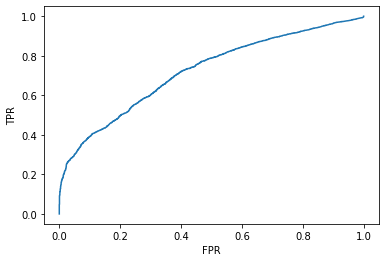

In [38]:
from matplotlib import pyplot as plt
plt.plot(FPR,TPR)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.show()

In [39]:
Youdin = TPR-FPR
maxYoudinInd = np.where(Youdin == np.max(Youdin))
threshold = np.max(Youdin)*10

(array([888., 271., 205., 156.,  74.,  29.,  20.,   7.,   4.,   1.]),
 array([0.33776993, 0.70704536, 1.07632079, 1.44559622, 1.81487166,
        2.18414709, 2.55342252, 2.92269796, 3.29197339, 3.66124882,
        4.03052425]),
 <a list of 10 Patch objects>)

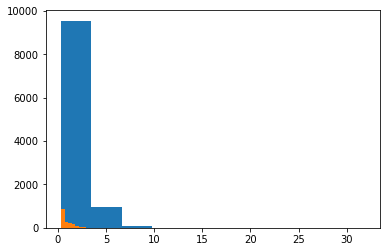

In [40]:
plt.hist(NoFallValdLossesAll)
plt.hist(FallValdLossesAll)

In [41]:
print(TPR[maxYoudinInd])
print(FPR[maxYoudinInd])

[0.72084238]
[0.4]


In [49]:
positive_cases = fall_youden_losses
negative_cases = no_fall_youden_losses
validation_positive_cases = fall_validation_losses
validation_negative_cases = no_fall_validation_losses

all_cases = []
all_positive_cases = []
all_negative_cases = []

# each of the positive cases consist of a sample, each sample can be seen as a bunch of losses
# [61, 60, 374, 4] -> whole thing = 1 activity, the 61 losses for each sample are just 1 float value
# we want to extract each sample loss into an overall array for youdin index calculation
for positive_case in positive_cases:
    for sample in positive_case:
        all_cases.append(sample)
        all_positive_cases.append(sample)

for negative_case in negative_cases:
    for sample in negative_case:
        all_cases.append(sample)
        all_positive_cases.append(sample)
all_cases_sorted = np.sort(all_cases)
# here we will find the youden index to find a suitable threshold, then test it on the validation set
N = all_cases_sorted.shape[0]
print(max(all_cases_sorted))
TPR = []
FPR = []

# sum all losses where the value is smaller than the index we are looking at, and divide by total number of positive cases
# do same for the negative
# we then add these into our TPR and FPR arrays
# next we want to subtract FPR from the TPR, and find the maximum value -> gives us the threhold.

# current issue somewhere here? ???? HEH
for k in range(N):
    positive_sum_to_insert = np.sum(all_positive_cases < all_cases_sorted[k])/(len(all_positive_cases))
    negative_sum_to_insert = np.sum(all_negative_cases < all_cases_sorted[k])/(len(all_negative_cases))
    TPR.append(positive_sum_to_insert)
    FPR.append(negative_sum_to_insert)
# print(TPR)
# print(FPR)
youdin =  np.array(TPR) - np.array(FPR)
youdin = youdin
threshold = np.max(youdin)
print(youdin)
# max_youdin_index = (np.where(youdin == np.max(youdin))[0][0])
# now to test accuracy of the model on unseen data
fall_sample_count = len(fall_validation_losses)
no_fall_sample_count = len(no_fall_validation_losses)


y_predicted = []
y_true = []
falls_predicted_true = 0
threshold = 1.9
for sample in fall_validation_losses:
    y_true.append(1)
    fall = False
    for data in sample:
        if data >= threshold:
            falls_predicted_true = falls_predicted_true + 1
            fall = True
            break
    if fall == True:
        y_predicted.append(1)
    else:
        y_predicted.append(0)


no_fall_predicted_false = 0
for sample in no_fall_validation_losses:
    fall = False;
    y_true.append(0)
    for data in sample:
        if data >= threshold:
            no_fall_predicted_false = no_fall_predicted_false + 1
            fall = True
            break
    if fall == True:
        y_predicted.append(1)
    else:
        y_predicted.append(0)
        
print(falls_predicted_true/fall_sample_count*100, " = percentage of falls predicted correctly")
print(((no_fall_sample_count - no_fall_predicted_false)*100)/no_fall_sample_count, " = percentage of no-falls predicted correctly")
print("\n")

61.119312


/home/z5075490/.venvs/mmWave/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in long_scalars


[nan nan nan ... nan nan nan]
15.18987341772152  = percentage of falls predicted correctly
38.97435897435897  = percentage of no-falls predicted correctly




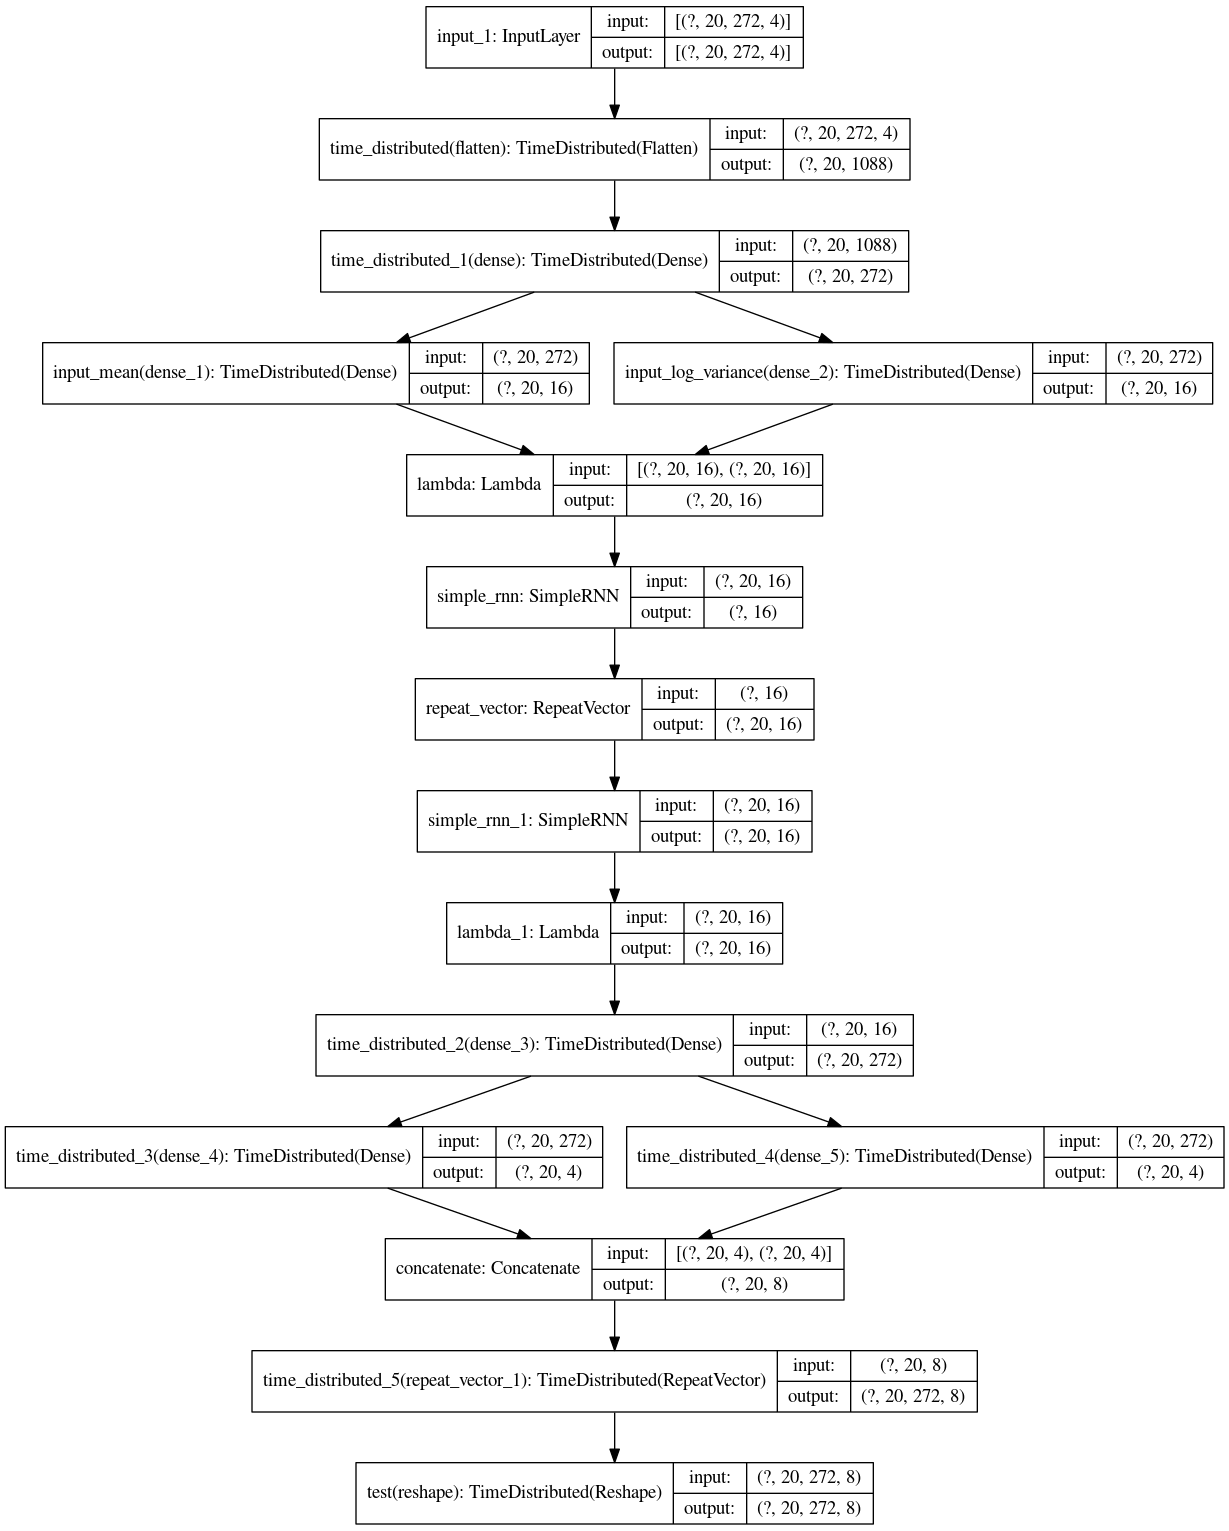

In [43]:
# from tf.keras.utils.vis_utils import 
# from importlib import reload
# reload(keras.utils.vis_utils)


from tensorflow.keras.utils import plot_model   

tf.keras.utils.plot_model(model, to_file="model.png", show_shapes=True, show_layer_names=True)

NameError: name 'f1_scores' is not defined

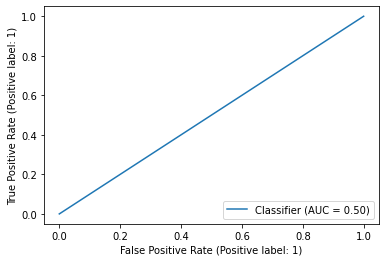

In [44]:
from sklearn.datasets import make_classification
from sklearn.metrics import RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss  
from sklearn.metrics import roc_auc_score

# 1 = fall
# 0 = ADL
falls_predicted = []
falls_true = []

ADL_predicted = []
ADL_true = []
all_true = y_true
all_predicted = y_predicted
for i in range(len(y_predicted)):
    if(y_true[i] == 1):
        falls_predicted.append(y_predicted[i])
        falls_true.append(y_true[i])
    else:
        ADL_predicted.append(y_predicted[i])
        ADL_true.append(y_true[i])

RocCurveDisplay.from_predictions(all_true, all_predicted)

f1_score = f1_score(all_true, all_predicted, average='binary')
precision_recall = precision_recall_fscore_support(all_true, all_predicted, average='binary',)
acc_fall = accuracy_score(falls_true, falls_predicted)
acc_adl = accuracy_score(ADL_true, ADL_predicted)
acc_all = accuracy_score(all_true, all_predicted)
log_losses = log_loss(all_true, all_predicted)
auc = roc_auc_score(all_true, all_predicted)
print("F1 Scores:", f1_scores)
print("precision, recall: ", precision_recall)
print("fall accuracy: ", acc_fall, "\nADL accuracy: ", acc_adl,"\ntotal_accuracy: ", acc_all)
print("log loss: ", log_losses)
print("auc: ", auc)